## Рекуррентная нейросеть для определения тональности текста отзывов на фильмы из IMDb с использованием представления входного текста плотными векторами


## Набор данных IMDb movie review

[Набор данных IMDb movie review](https://ai.stanford.edu/~amaas/data/sentiment/) создан для задач определения тональности текста. Набор включает отзывы на фильмы с сайта [IMDb](https://www.imdb.com). Отзывы только явно положительные (оценка >= 7) или отрицательные (оценка <= 4), нейтральные отзывы в набор данных не включались.

Размер набора данных 50 тыс. отзывов:
- Набор данных для обучения - 25 тыс. отзывов
- Набор данных для тестирования - 25 тыс. отзывов

Количество положительных и отрицательных отзывов одинаковое.

Разметка набора данных:
- 0 - отзыв отрицательный
- 1 - отзыв положительный

С точки зрения машинного обучения это задача бинарной классификации.

Набор данных описан в статье: [Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf).

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, SimpleRNN
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
from utils.utils import *
%matplotlib inline 

Определяем максимально возможное количество слов, те слова которые встречаются реже чем слово с указанным индексом в словаре игнорируются


In [3]:
max_words = 10000

## Загружаем данные

In [4]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)

## Просмотр данных

Рецензия

In [5]:
x_train[5]

[1,
 778,
 128,
 74,
 12,
 630,
 163,
 15,
 4,
 1766,
 7982,
 1051,
 2,
 32,
 85,
 156,
 45,
 40,
 148,
 139,
 121,
 664,
 665,
 10,
 10,
 1361,
 173,
 4,
 749,
 2,
 16,
 3804,
 8,
 4,
 226,
 65,
 12,
 43,
 127,
 24,
 2,
 10,
 10]

Ожидаемый эмоциональный окрас

In [6]:
y_train[5]

0

## Подготовка данных для обучения

Длина слов к которой приводится каждая рецензия

In [7]:
maxlen = 200

Так как для работы нейросети первый слой обязан быть фиксированной длины, используем pad_sequences для обрезки или дополнения вектора с рецензией до maxlen. В случае короткой рецензии проставляем нули с левой стороны, потому что простая рекуррентная сеть имеет ограниченную область запоминания предыдущего контекста слов в последовательности и если в конце будут нули то рекуррентная сеть преимущественно будет анализировать эти нули 

In [8]:
x_train = pad_sequences(x_train, maxlen=maxlen, padding='pre')
x_test = pad_sequences(x_test, maxlen=maxlen, padding='pre')

In [9]:
x_train[5]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Создание нейронной сети


Входной слой оборачиваем в Embedding преобразующий его в массив слов, где каждое слово каждое слово представлено вектором из 3х элементов. Вектора для каждого слова обучаются с помощью back propagation

In [11]:
model = Sequential()
model.add(Embedding(max_words, 3, input_length=maxlen))

output shape=(None, 200, 3)

Добавляем слой рекуррентной слой на 8 нейронов

In [12]:
model.add(SimpleRNN(8))

Зануляем случайную половину весов при каждом forward шаге на этапе обучения для уменьшения эффекта переобучения

In [13]:
model.add(Dropout(0.5))

Добавляем выходной слой

In [14]:
model.add(Dense(1, activation='sigmoid'))

output shape=(None, 1)

Выбираем оптимизатор градиентного спуска, функцию потерь и оценку качества чтобы потом можно было визуализировать


In [15]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [16]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=10,
                    batch_size=128,
                    validation_split=0.1)

Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.5384 - loss: 0.6885 - val_accuracy: 0.7396 - val_loss: 0.5983
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7764 - loss: 0.5412 - val_accuracy: 0.8372 - val_loss: 0.4217
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8407 - loss: 0.4224 - val_accuracy: 0.8392 - val_loss: 0.3806
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8504 - loss: 0.3854 - val_accuracy: 0.8500 - val_loss: 0.3647
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8862 - loss: 0.3229 - val_accuracy: 0.8500 - val_loss: 0.3666
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8987 - loss: 0.2961 - val_accuracy: 0.8544 - val_loss: 0.3668
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9150 - loss: 0.2654 - val_accuracy: 0.8568 - val_loss: 0.3794
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9227 - loss: 0.2483 - val_accu

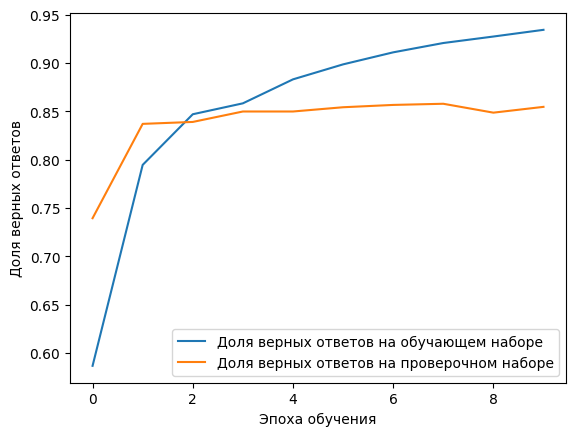

In [17]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Проверяем работу сети на тестовом наборе данных

In [18]:
scores = model.evaluate(x_test, y_test, verbose=1)

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8386 - loss: 0.4154
